# Dynamical Decoupling with IBM Simulator/ QC

In [1]:
import numpy as np
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit import transpile, schedule as build_schedule
%matplotlib inline

In [2]:
# Build noise model from backend properties
provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_vigo')
backend = provider.get_backend('ibmq_ourense')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [8]:
qcf = QuantumCircuit(1, 1)
num_Is = 0
cycles = 1
tot_gates = 4
#qcf.h(0)
for i in range(tot_gates * cycles):
    qcf.barrier(0)
    qcf.id(0)
    for j in range(num_Is):
        qcf.barrier(0)
        qcf.id(0)
qcf.barrier(0)
qcf.measure(0,0)

In [9]:
transpiled_circ = transpile(qcf, backend) 
schedule = build_schedule(transpiled_circ, backend)
transpiled_circ.draw()

░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌─┐
q_0: ─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤M├
      ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └╥┘
c_0: ════════════════════════════════════╩═

In [10]:
inst_map = backend.defaults().instruction_schedule_map
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'id', 'u3', 'u2', 'measure', 'u1', 'x'}
Multi qubit instructions:
)>


## Testing the Ideal XY4 Pulse Sequence with Armonk Noise Simulation
$$ XY4 = Y.f.X.f.Y.f.X.f $$

In [3]:
## an 8 tau circuit without DD (just free evolution)
qcf = QuantumCircuit(1, 1)
num_Is = 0
cycles = 1
tot_gates = 4
#qcf.h(0)
for i in range(tot_gates * cycles):
    qcf.barrier(0)
    qcf.id(0)
    for j in range(num_Is):
        qcf.barrier(0)
        qcf.id(0)
qcf.barrier(0)
qcf.measure(0,0)
qcf.draw()

░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌─┐
q_0: ─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤M├
      ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └╥┘
c_0: ════════════════════════════════════╩═

In [11]:
transpiled_circ = transpile(qcf, backend) 
schedule = build_schedule(transpiled_circ, backend)
transpiled_circ.draw()

░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌─┐
q_0: ─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤M├
      ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └╥┘
c_0: ════════════════════════════════════╩═

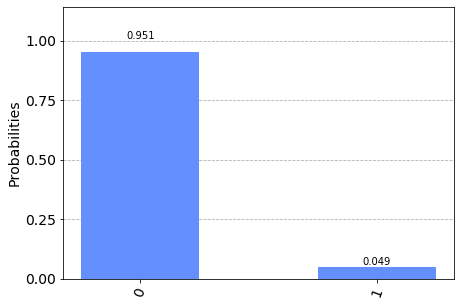

In [4]:
result = execute(qcf, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [13]:
def xy4(circ, cycles, num_Is):
    #circ.h(0)
    for j in range(cycles):
        circ.barrier(0)
        circ.y(0)
        circ.barrier(0)
        for i in range(num_Is):
            circ.id(0)
        circ.barrier(0)
        circ.x(0)
        circ.barrier(0)
        for i in range(num_Is):
            circ.id(0)
        circ.barrier(0)
        circ.y(0)
        circ.barrier(0)
        for i in range(num_Is):
            circ.id(0)
        circ.barrier(0)
        circ.x(0)
        circ.barrier(0)
        for i in range(num_Is):
            circ.id(0)
        circ.barrier(0)
    circ.measure(0, 0)
    
    return circ

In [14]:
## implementing the XY4 sequence
qc4 = QuantumCircuit(1, 1)
xy4(qc4, cycles, num_Is)
qc4.draw()

░ ┌───┐ ░  ░ ┌───┐ ░  ░ ┌───┐ ░  ░ ┌───┐ ░  ░ ┌─┐
q_0: ─░─┤ Y ├─░──░─┤ X ├─░──░─┤ Y ├─░──░─┤ X ├─░──░─┤M├
      ░ └───┘ ░  ░ └───┘ ░  ░ └───┘ ░  ░ └───┘ ░  ░ └╥┘
c_0: ════════════════════════════════════════════════╩═

In [14]:
transpiled_circ = transpile(qc4, backend) 
schedule = build_schedule(transpiled_circ, backend)
transpiled_circ.draw()

░ ┌──────────────────┐ ░  ░ ┌─────────────┐ ░  ░ ┌──────────────────┐ ░ »
q_0: ─░─┤ U3(pi,pi/2,pi/2) ├─░──░─┤ U3(pi,0,pi) ├─░──░─┤ U3(pi,pi/2,pi/2) ├─░─»
      ░ └──────────────────┘ ░  ░ └─────────────┘ ░  ░ └──────────────────┘ ░ »
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ░ ┌─────────────┐ ░  ░ ┌─┐
«q_0: ─░─┤ U3(pi,0,pi) ├─░──░─┤M├
«      ░ └─────────────┘ ░  ░ └╥┘
«c_0: ═════════════════════════╩═
«

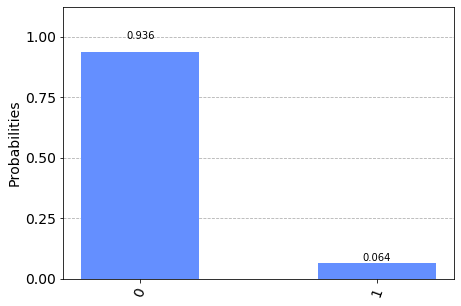

In [15]:
result = execute(qc4, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [49]:
counts

{'1': 513, '0': 511}

## Testing the Ideal XY4 Pulse Sequence with Armonk QPU
$$ XY4 = Y.f.X.f.Y.f.X.f $$

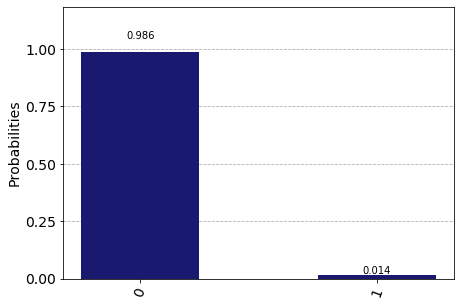

In [4]:
job = execute(qcf, backend, shots=1000)
plot_histogram(job.result().get_counts(), color='midnightblue')

In [17]:
job.error_message()

'Instruction not in basis gates: instruction: MEASTRIG, qubits: [0], params: []. Error code: 7000.'

In [18]:
job = execute(qc4, backend, shots=4000)
plot_histogram(job.result().get_counts(), color='midnightblue')

IBMQJobFailureError: 'Unable to retrieve result for job 5eae4fa55b4fb90012f80ab1. Job has failed. Use job.error_message() to get more details.'

In [20]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'id', 'u3', 'u2', 'measure', 'u1', 'x'}
Multi qubit instructions:
)>


In [21]:
job.error_message()

'Instruction not in basis gates: instruction: MEASTRIG, qubits: [0], params: []. Error code: 7000.'

# Outline of Project
## Monday 27 April 2020
## RNB (Revanth, Nic, Bruno)

## 1. get simulators/QPUs to run robust genetic algorithm (RGAx) sequences
### * see eq. 27, 40, E12, Tables II - IV
### * We'll try identities with nothing more for free evolution, ignore $H_0$ in eq. 40?, ignore $\epsilon$ (which should be out of our control), and play around with values of $\tau_p$ (pulse app time)

## 2. Get QPU details and find "good" parameters
### * $J = ||H_{err}||$, $\beta = ||H_B||$, $\tau_p$, $\tau_d$ (pulse interval)

## 3. Check whether RGAx actually improves coherence
### * compare to standard easy schemes like CDD

## 4. Check whether RGA4 is actually optimal by exhaustive enumeration (experimentally but with same assumptions about Pulse-free-pulse-free etc... to have reasonable size search space)

## 5. Check Pulse interval scaling relationships
### *i.e. O($\tau_d^n$)
### * could be interesting also to try and adjust $\epsilon$, $J$, $\beta$, and $H_0$ manually via phase gates, coupling to *ancilla* qubits, etc...
### *perhaps need to learn and use Pulse API for above bullet--but the API is not well explained on the docs (or at least not intutive to me)

## 6. Contingent upon (5) a bit, see how RGAx compares to other DD methods behave under more serious pulse specification errors

# -------
# Bonus Material:

## 7~) see how optimized fixed pulse interval sequences RGAx compare to sequences compare to non-simple DD methods such as UDD
### * doing UDD, for example, probably relies on having gotten Pulse API to work--otherwise "precisely" timing pusles with simple native gates is probably not good enough 

## 8~) try to implement our DD scheme with an actual computation and see if it improves fidelity
### *Issue: How to apply gates with interfereing with each other? Could just make $\tau_d$ bigger... but too big and errors accumulate too fast?

## 9~) "Force" J, $\beta$ values by coupling single qubit to ancillas 
### * If we can get 8 to work, surely we can do this? 